In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
% matplotlib inline
#check to see if I can control how big each holdout set is, do with rms error
from sklearn.cross_validation import cross_val_score as cvs
from sklearn.cross_validation import KFold

In [ ]:
file_location = 

#Import Data

In [3]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'D0_clean_features.csv', parse_dates = [0], index_col = 0)
print df_all[:5]

IOError: File D0_clean_features.csv does not exist

###Delete the unfiltered data

In [3]:
#df_all.drop(df_all.columns[[1]], axis=1, inplace=True)
#print df_all[:5]

##Declare whether to process raw or filtered data.

In [4]:
which_data = 0    #1 = filtered, 0 = raw
if which_data == 1:
    ref_column = 'O3_ppb'
    leave_out_pod = 'e2v03'
else:
    ref_column = 'ref_o3_smooth'
    leave_out_pod = 'pod_o3_smooth'

#Forward Selection for Random Forests


In [5]:
import random
import sys
from scipy import stats
from sklearn import linear_model

###Evaluate Critical Function


In [6]:
#make numpy arrays out of the training and holdout data
def df_subset(features, df_F, df_H):
    X_F = df_F[features].values
    X_H = df_H[features].values
    y_F = df_F[ref_column].values
    y_H = df_H[ref_column].values
    return X_F, y_F, X_H, y_H

import sklearn.ensemble as sk
#fit random forest and finds RSS
def crit_func(features, df_F, df_H):
    #Set up the random forest regression features
    rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
    X_F, y_F, X_H, y_H = df_subset(features, df_F, df_H)
    #fit a linear regression on the training data
    rfr.fit(X_F, y_F)    
    #find the normalized RSS for the training and holdout data
    return sum((y_H - rfr.predict(X_H)) ** 2)/len(y_H), sum((y_F - rfr.predict(X_F)) ** 2)/len(y_F)

###Forward-selection using leave-one-day-out cross validation:

In [7]:
#define function that iteratively adds remaining features to best features to see which is most important
def forward_selection_step(b_f, features, df_F, df_H):
    #initialize min_RSS with a very large number
    min_RSS = sys.maxint
    next_feature = ''
    for f in features:
        #call the func that finds RSS, using arguments it's called with. First argument is best features + whichever one 
        #we're on in this iteration.
        RSS_H, RSS_F = crit_func(b_f + [f], df_F, df_H)
        if RSS_H < min_RSS:
            min_RSS = RSS_H
            next_feature = f
    return next_feature

In [8]:
def forward_selection_lodo(features, df):
    #initialize the best_features list with the base features to force their inclusion
    best_features = []
    #create a 'day' column in the dataframe by mapping the index column
    df['day'] = df.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
    days = df['day'].unique()
    
    RSS_F_list = []
    RSS_H_list = []
    while len(features) > 0:
        next_features = []
        #loop through every single day for the cross-validation
        for d in days:
            #Leave-one-out cross-validation. third agrument is training days (not selected day), fourth is holdout day. 
            f = forward_selection_step(best_features, features, df[df.day != d], df[df.day == d])
            #forward_selection_step returns the next feature, which is added to the next-features list. For every day, 
            #a different possible best feature is chosen, and they're all put in this list
            next_features += [f]
        #take the mode of the best features list from all cross-validation days (vote)
        next_feature = stats.mode(next_features)[0][0]
        #add the chosed best feature to the list
        best_features += [next_feature]
        #remove the chosen feature from the list
        features.remove(next_feature)
        
        #prints the result of the vote- shows you how many days voted for that feature
        print stats.mode(next_features)
        
        #initizlize the holdout and training RSS
        RSS_H = 0
        RSS_F = 0

        #So that we can plot them below, calculate the training and holdout RSS for each step.
        #take the mean RSS for all of the possible holdout days (giving cross-validation error)
        for d in days:
            RSS_H_temp, RSS_F_temp= crit_func(best_features, df[df.day != d], df[df.day == d])
            RSS_H += RSS_H_temp
            RSS_F += RSS_F_temp

            
        RSS_H_list += [RSS_H / len(days)]
        RSS_F_list += [RSS_F / len(days)]

    #drop the day column
    df.drop('day', axis=1, inplace=True)
    return best_features, RSS_F_list, RSS_H_list

####Try it!

In [9]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
#this lets you leave out anything you want
leave_out = ['O3_ppb','ref_o3_smooth','Zenith Angle [degrees]','days from start','UnixTime',leave_out_pod]
#make a new list of features without the ones in leave_out
features = [f for f in features if f not in leave_out]

In [ ]:
fs_features, RSS_F, RSS_H, MSE_H, MSE_F  = forward_selection_lodo(features, df_all[[ref_column] + features].dropna())
print fs_features

In [ ]:
x = range(1, len(RSS_F)+1)
plt.figure()
plt.plot(x, RSS_F, 'ro-')
plt.ylabel('Normalized Training RSS')
plt.figure()
plt.plot(x, RSS_H, 'bo-')
plt.xlabel('Number of Features')
plt.ylabel('Normalized Holdout RSS')

#Enter the number of good features to use for regressions.

In [70]:
num_good_feat = 7
fs_features[:num_good_feat]

['temp_int_75',
 '03_mult_temp_sq',
 'e2v03',
 'rh_int_75',
 '03_mult_temp',
 'rh_sq',
 'O3_cu',
 'rh_cu',
 'Rh',
 'temp_mult_rh_sq',
 'temp_mult_rh_cu',
 'temp_mult_rh',
 'temp_int_60',
 '03_mult_rh_&_temp_cu',
 '03_mult_rh_&_temp']

#Check Residuals

In [72]:
df_fit = df_all[fs_features[:15] + [ref_column]].dropna()
X = df_fit[fs_features[:15]].values
y = df_fit[ref_column].values

In [73]:
regr = linear_model.LinearRegression()
regr.fit(X,y)
df_fit['O3_fit'] = regr.predict(X)

In [74]:
print ("Residual sum of squares: %.2f" %
        np.mean((df_fit.O3_fit - df_fit.O3_fit) ** 2))

Residual sum of squares: 0.00


In [78]:
#find the residuals
lin_resid = df_fit.O3_ppb - df_fit.O3_fit

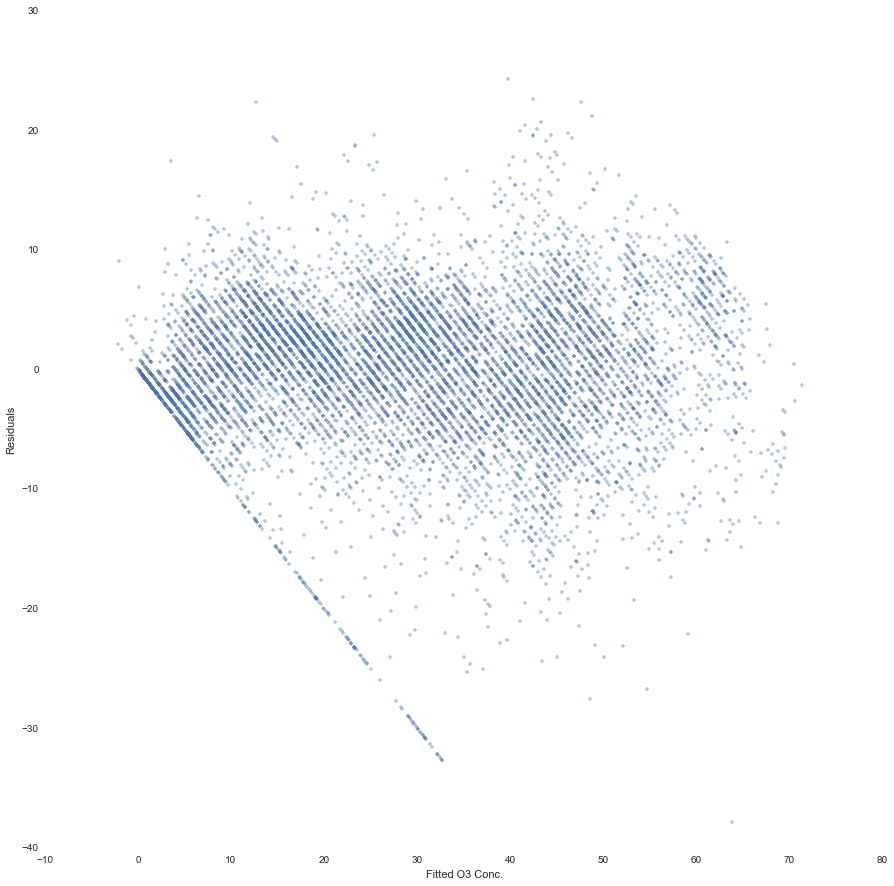

In [79]:
#plot the residuals to check for non-linearity of response predictor
plt.figure(figsize = (15,15))
plt.plot(df_fit.O3_fit,lin_resid,linestyle = '',marker = '.',alpha = 0.4)
#plt.plot([0,0],[70,0])
plt.xlabel('Fitted O3 Conc.')
plt.ylabel('Residuals')

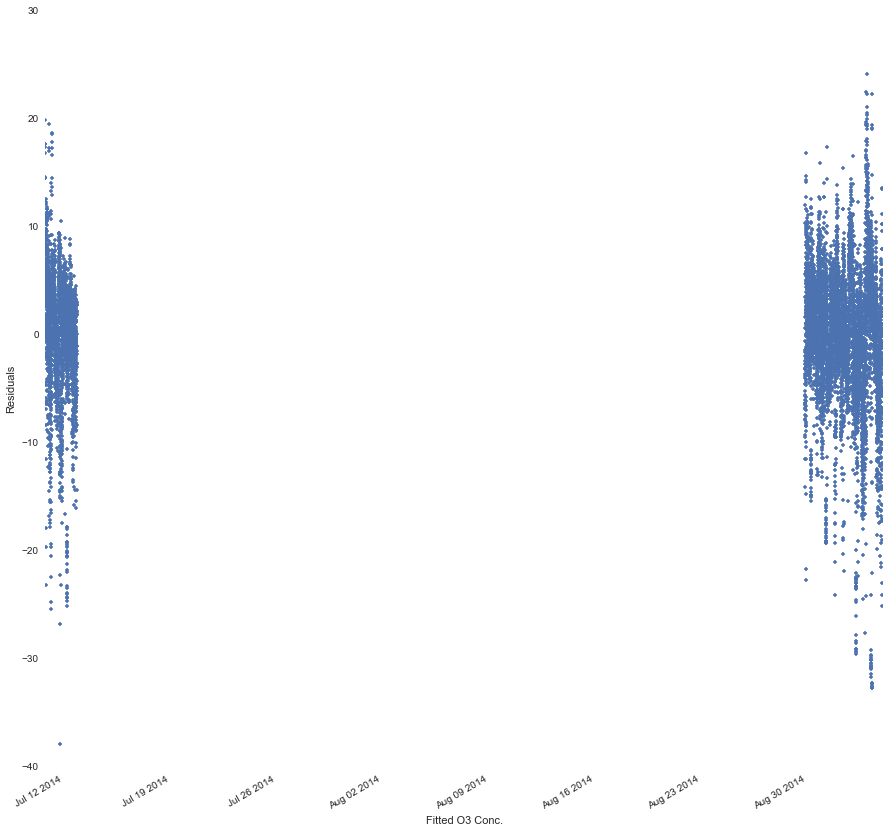

In [82]:
plt.figure(figsize = (15,15))
lin_resid.plot(linestyle = '',marker = '.')
#plt.plot([0,0],[70,0])
plt.xlabel('Fitted O3 Conc.')
plt.ylabel('Residuals')

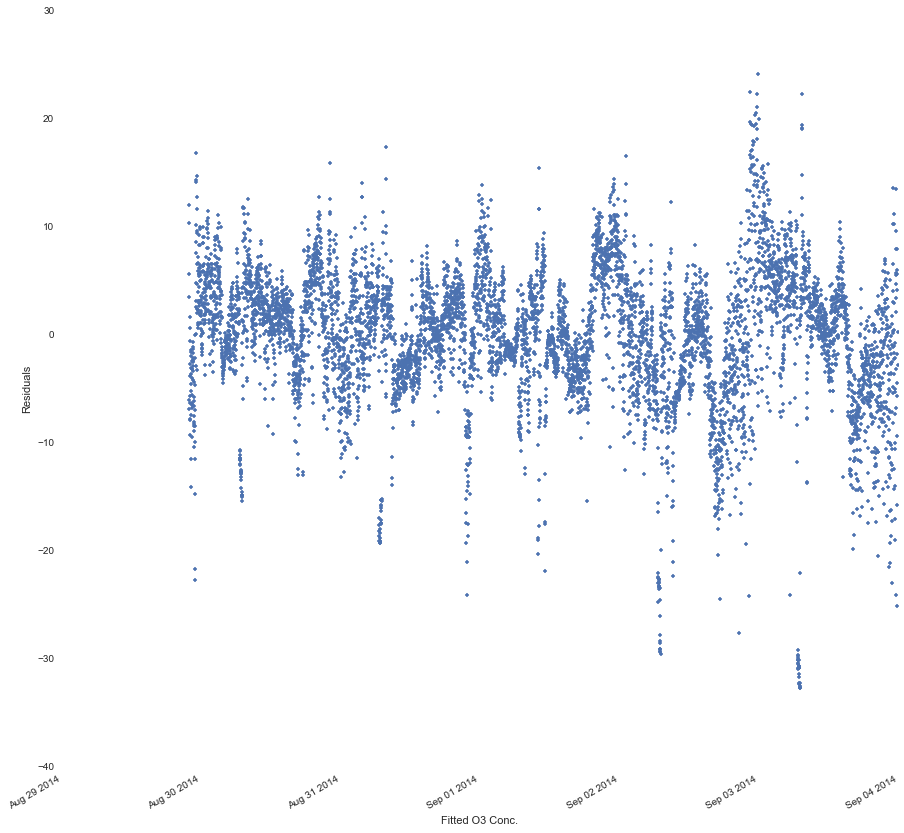

In [84]:
plt.figure(figsize = (15,15))
lin_resid.plot(linestyle = '',marker = '.', xlim=['2014-08-29 00:00:00', '2014-09-4 00:00:00'])
#plt.plot([0,0],[70,0])
plt.xlabel('Fitted O3 Conc.')
plt.ylabel('Residuals')

In [233]:
# Explained variance score: 1 is perfect prediction
print ('Variance score: %.2f' % regr.score(diabetes_X_test, diabetes_y_test))

NameError: name 'diabetes_X_test' is not defined

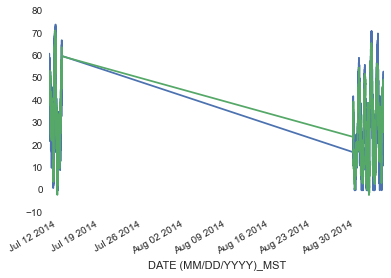

In [86]:
df_fit.O3_ppb.plot()
df_fit.O3_fit.plot()

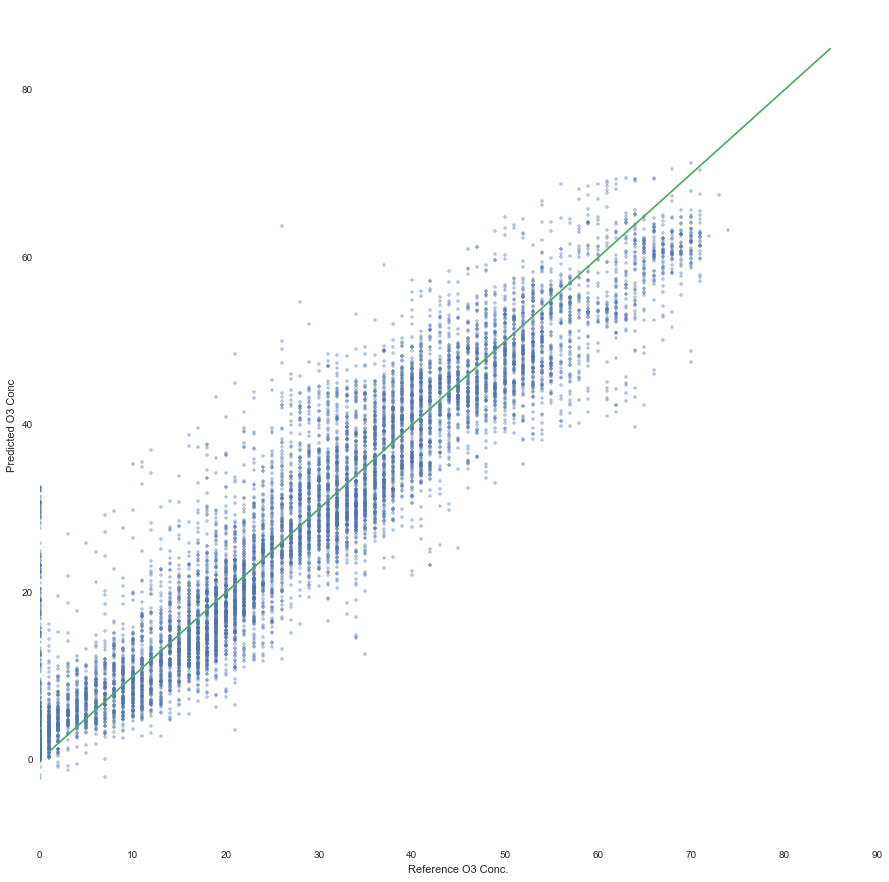

In [87]:
plt.figure(figsize = (15,15))
plt.plot(df_fit.O3_ppb,df_fit.O3_fit,linestyle = '',marker = '.',alpha = 0.4)
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85])

In [414]:
df_all[fs_features]

,rh_int_75,rh_int_60,Rh,03_mult_rh_cu,03_mult_temp_cu,03_mult_temp,03_mult_rh_&_temp,03_mult_rh_sq,temp_sq,temp_int_75,...,temp_mult_rh,rh_int_30,rh_int_45,temp_int_45,e2v03,pod_o3_smooth,temp_int_30,O3_sq,rh_cu,rh_sq
DATE (MM/DD/YYYY)_MST,,,,,,,,,,,,,,,,,,,,,
2014-07-10 21:40:00,858.607143,692.032143,11.985714,1.449780e+09,65093714642,4022.657143,48214.41918,1280957.3810,1814.760000,3280.654762,...,510.591429,344.354762,517.130952,1919.723810,94.428571,94.428571,1248.616667,8916.755102,1721.835915,143.657347
2014-07-10 21:41:00,859.228571,692.754762,11.985714,1.347029e+09,60723991945,3930.551020,47110.46152,1219694.8520,1819.631837,3277.433333,...,511.276326,344.647619,517.352381,1917.395238,92.142857,92.142857,1247.077381,8490.306122,1721.835915,143.657347
2014-07-10 21:42:00,859.907143,693.361905,12.000000,1.358148e+09,61190930735,3940.600000,47287.20000,1226398.0410,1823.290000,3274.226190,...,512.400000,344.976190,517.523809,1915.088095,92.285714,92.285714,1245.695238,8516.653061,1728.000000,144.000000
2014-07-10 21:43:00,860.600000,693.876191,12.100000,1.334997e+09,59082040227,3894.800000,47127.08000,1212421.2100,1831.840000,3271.026190,...,517.880000,345.397619,517.892857,1912.845238,91.000000,91.000000,1244.473810,8281.000000,1771.561000,146.410000
2014-07-10 21:44:00,861.271429,694.333333,12.000000,1.535659e+09,70025293675,4121.781633,49461.37959,1331056.6530,1837.959388,3267.876190,...,514.457143,345.883333,518.433333,1910.695238,96.142857,96.142857,1243.430952,9243.448980,1728.000000,144.000000
2014-07-10 21:45:00,861.957143,694.683333,12.085714,2.010365e+09,90274309470,4485.953061,54215.94700,1592880.9560,1845.316122,3264.811905,...,519.167755,346.333333,518.883333,1908.680952,104.428571,104.428571,1242.545238,10905.326530,1765.293691,146.064490
2014-07-10 21:46:00,862.807143,694.929762,11.985714,1.707119e+09,78827456684,4287.714286,51391.31837,1428376.2050,1849.000000,3261.854762,...,515.385714,346.776190,519.419048,1906.795238,99.714286,99.714286,1241.830952,9942.938776,1721.835915,143.657347
2014-07-10 21:47:00,863.764286,695.083333,11.914286,1.577895e+09,74400775115,4205.902041,50110.31860,1355352.1360,1852.687551,3259.011905,...,512.824898,347.195238,519.983333,1904.959524,97.714286,97.714286,1241.282143,9548.081633,1691.235289,141.950204
2014-07-10 21:48:00,864.692857,695.133333,11.857143,1.508037e+09,72211690136,4164.240816,49375.99825,1315047.2640,1853.917551,3256.233333,...,510.534694,347.471429,520.397619,1903.152381,96.714286,96.714286,1240.883333,9353.653061,1667.017493,140.591837


In [6]:
fs_features = ['temp_int_75','03_mult_temp_sq','e2v03','rh_int_75', '03_mult_temp','rh_sq','O3_cu','rh_cu','Rh','temp_mult_rh_sq','temp_mult_rh_cu','temp_mult_rh']
#'Zenith Angle [degrees]',

#Random Forest

In [7]:
#make numpy arrays out of the training and holdout data
def make_numpy_arrays_for_tr_and_holdout(features, df_T, df_H):
    X_T = df_T[features].values
    X_H = df_H[features].values
    y_T = df_T['O3_ppb'].values
    y_H = df_H['O3_ppb'].values
    return X_T, y_T, X_H, y_H

In [11]:
import sklearn.ensemble as sk
i_max = 12 # max features
j_max = 160 # max depth
i_min = 0
j_min = 0

#fit random forest and finds MSE
def fit_rfr_and_find_MSE(features, df_F, df_H,d):
    #initialize the numpy array that will hold the test-mse data
    mse_array_test = np.zeros((i_max,j_max))
    mse_array_train = np.zeros((i_max,j_max))
    
    #loop through all combinations of max_features and max_depth
    for i in range(i_min,i_max):
        j = j_min
        while j < j_max:
            #Set up the random forest regression features
            rfr = sk.RandomForestRegressor(n_estimators=250, oob_score = True, n_jobs = -1, max_features = i+1, max_depth = j+1)
            #forest = sk.RandomForestClassifier(n_estimators=100, random_state=0)
                        
            #call the r=function that defines the trainig and holdout data
            X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])
                
            #fit a linear regression on the training data
            rfr.fit(X_T, y_T)  
            #plot_importance(rfr, forest)
            
            #add the mse for each i and j to the 2D array (i is on one axis, j is on the other, and mse is a grid)
            mse_array_test[i,j] = int(np.mean((y_H - rfr.predict(X_H))**2))
            mse_array_train[i,j] = int(np.mean((y_T - rfr.predict(X_T))**2))
            
            print d,i,j,int(np.mean((y_H - rfr.predict(X_H))**2))
            j += 10
               
    #find the MSE for the training and holdout data
    return mse_array_test, mse_array_train

In [12]:
def plot_importance(rfr,forest):
    importances = rfr.feature_importances_
    std = np.std([rfr.feature_importances_ for rfr in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    #print("Feature ranking:")
    #for f in range(5):
        #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    #Plot the feature importances of the forest
    #plt.figure(figsize=(15,5))
    #plt.title("Feature importances")
    #plt.bar(range(len(fs_features)), importances[indices],  color="r", align="center")
    #plt.xticks(range(len(fs_features)), indices)
    #plt.xlim([-1, len(fs_features)])
    #plt.show()

In [13]:
# define the dataset
import sklearn.preprocessing as pp
#Set up the feature scaling, so that every feature of the data goes from 0 to 1
mms = pp.MinMaxScaler(feature_range=(0, 1), copy=True)
df_fit_sc = df_all[fs_features].apply(lambda x: mms.fit_transform(x))

df_fit = pd.concat([df_fit_sc, df_all.O3_ppb], axis = 1)

#create a 'day' column in the dataframe by mapping the index column
df_fit['day'] = df_fit.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
days = df_fit['day'].unique()
        
#initialize the holdout and training RSS
MSE_T = []
MSE_H = [] 
day_date = []
count = 1
count_append = []
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
    MSE_H_day, MSE_T_day = fit_rfr_and_find_MSE(fs_features, df_fit[df_fit.day != d], df_fit[df_fit.day == d],d)
    day_date.append(d)
    count_append.append(count)
    if count == 1:
        MSE_H = MSE_H_day
        MSE_T = MSE_T_day
    else:
        MSE_H = np.dstack((MSE_H,MSE_H_day))
        MSE_T = np.dstack((MSE_T,MSE_T_day))
        
    count +=1

#drop the day column
df_fit.drop('day', axis=1, inplace=True)

7-10 0 0 156
7-10 0 10 81
7-10 0 20 90
7-10 0 30 85
7-10 0 40 91
7-10 0 50 87
7-10 0 60 82
7-10 0 70 81
7-10 0 80 80
7-10 0 90 85
7-10 0 100 95
7-10 0 110 83
7-10 0 120 98
7-10 0 130 88
7-10 0 140 95
7-10 0 150 85
7-10 1 0 143
7-10 1 10 85
7-10 1 20 70
7-10 1 30 65
7-10 1 40 83
7-10 1 50 74
7-10 1 60 73
7-10 1 70 79
7-10 1 80 69
7-10 1 90 74
7-10 1 100 73
7-10 1 110 80
7-10 1 120 82
7-10 1 130 71
7-10 1 140 75
7-10 1 150 77
7-10 2 0 192
7-10 2 10 78
7-10 2 20 72
7-10 2 30 82
7-10 2 40 76
7-10 2 50 73
7-10 2 60 84
7-10 2 70 76
7-10 2 80 76
7-10 2 90 72
7-10 2 100 72
7-10 2 110 73
7-10 2 120 73
7-10 2 130 71
7-10 2 140 69
7-10 2 150 82
7-10 3 0 171
7-10 3 10 79
7-10 3 20 74
7-10 3 30 71
7-10 3 40 78
7-10 3 50 70
7-10 3 60 80
7-10 3 70 69
7-10 3 80 74
7-10 3 90 67
7-10 3 100 75
7-10 3 110 76
7-10 3 120 70
7-10 3 130 77
7-10 3 140 73
7-10 3 150 77
7-10 4 0 172
7-10 4 10 79
7-10 4 20 76
7-10 4 30 72
7-10 4 40 71
7-10 4 50 67
7-10 4 60 66
7-10 4 70 71
7-10 4 80 79
7-10 4 90 75
7-10 4 100 77


In [14]:
#first array is  [[day 1, day 2, ..., day n (i = 0 & j = 0)] [day 1, day 2, ..., day n (i = 0, j = 1)] [day 1, day 2, ..., day n(i = 0, j = n)]
#second array is [[day 1, day 2, ..., day n (i = 1 & j = 0)] [day 1, day 2, ..., day n (i = 1, j = 1)] [day 1, day 2, ..., day n(i = 1, j = n)]
#nth array is [[day 1, day 2, ..., day n (i = n & j = 0)] [day 1, day 2, ..., day n (i = n, j = 1)] [day 1, day 2, ..., day n(i = n, j = n)]
print MSE_H

[[[ 156.  303.  176. ...,  300.  216.  124.]
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]
  ..., 
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]]

 [[ 143.  241.  184. ...,  260.  186.  132.]
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]
  ..., 
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]]

 [[ 192.  214.  170. ...,  250.  163.  137.]
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]
  ..., 
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]]

 ..., 
 [[  58.  244.  141. ...,  249.  142.  148.]
  [   0.    0.    0. ...,    0.    0.    0.]
  [   0.    0.    0. ...,    0.    0.    0.]
  ..., 
  [   0.  

In [15]:
MSE_H_per_day = MSE_H.mean(axis=2, dtype = int)
print MSE_H_per_day

[[174   0   0 ...,   0   0   0]
 [155   0   0 ...,   0   0   0]
 [152   0   0 ...,   0   0   0]
 ..., 
 [141   0   0 ...,   0   0   0]
 [141   0   0 ...,   0   0   0]
 [143   0   0 ...,   0   0   0]]


In [154]:
#np.ndarray.nonzero(MSE_H_per_day)

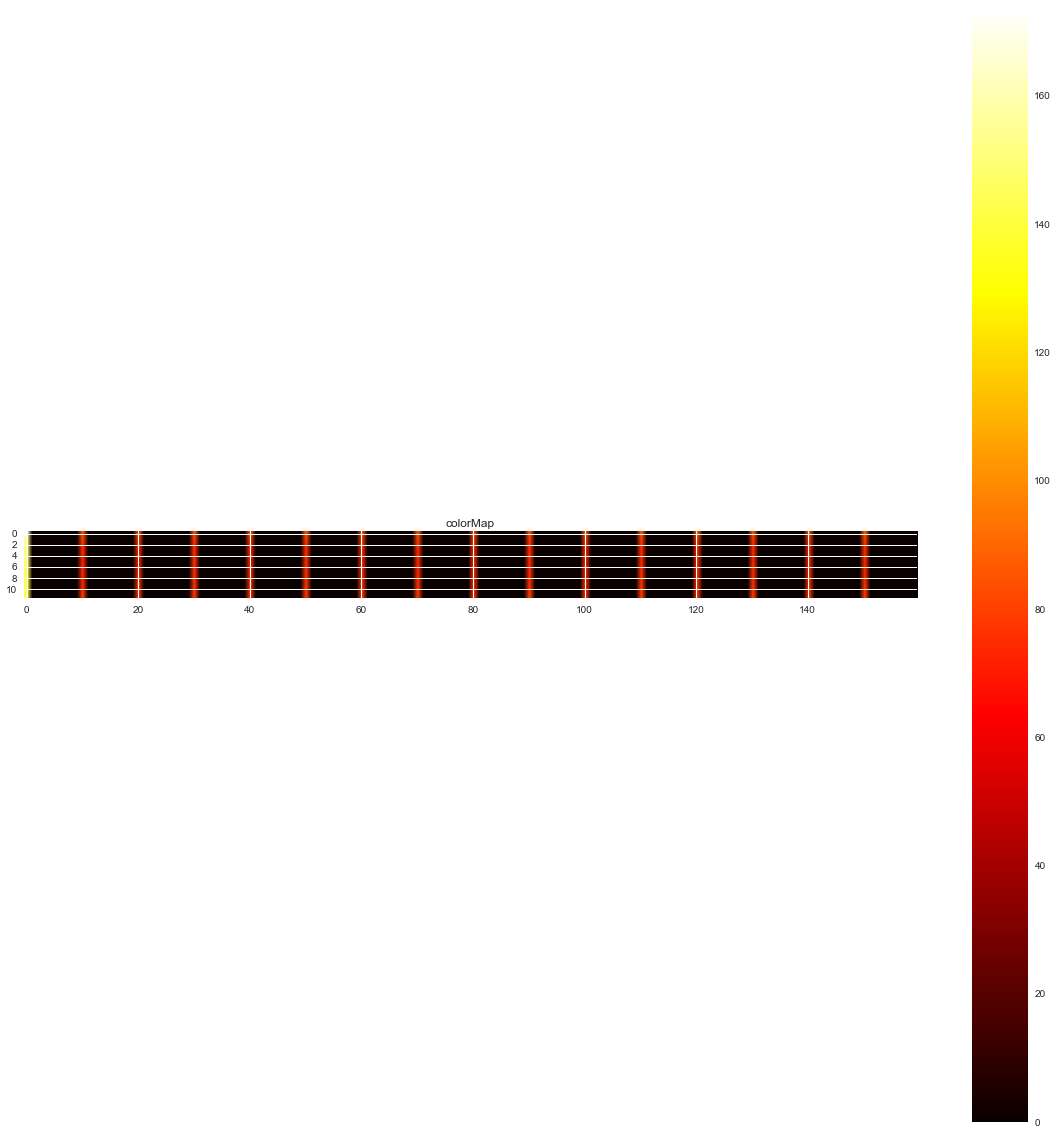

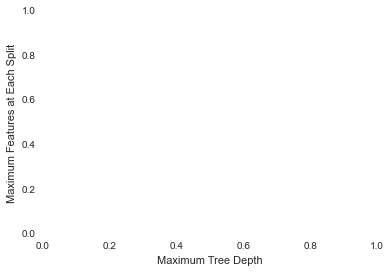

In [18]:
import matplotlib as ml

fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
imgplot = plt.imshow(MSE_H_per_day)
imgplot.set_cmap('hot')
#imgplot.set_clim(60,71)
ax.set_aspect('equal')

plt.colorbar(orientation='vertical')
plt.show()
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Maximum Features at Each Split')

In [149]:
min_MSE_H = MSE_H_per_day.min()
i,j = np.where(MSE_H_per_day == min_MSE_H)
i = i + 1
j = (j + 1)*5
print 'Max features = ' + str(i)
print 'Max depth = ' + str(j)
print 'MSE for the holdout data = ' + str(min_MSE_H)

Max features = [6 7 7]
Max depth = [35 30 35]
MSE for the holdout data = 65


In [ ]:
print 'mean MSE = ' + str(np.mean(MSE_H))
print 'Daily MSE = ' + str(MSE_H)

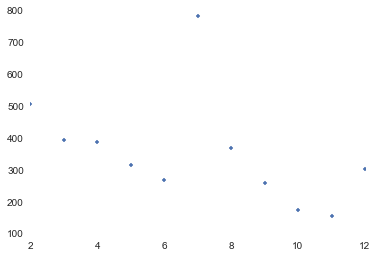

In [169]:
plt.plot(count_append, MSE_H, marker = '.', linestyle = ' ')

In [236]:
rfr.feature_importance_

NameError: name 'rfr' is not defined

In [3]:
import sklearn.ensemble as sk

#Set up the random forest regression features
rfr = sk.RandomForestRegressor(n_estimators=250, oob_score = True)
#max_features = 'sqrt',

import sklearn.preprocessing as pp
#Set up the feature scaling, so that every feature of the data goes from 0 to 1
mms = pp.MinMaxScaler(feature_range=(0, 1), copy=True)

In [4]:
#change 
#define the training data
df_fit = df_all[fs_features[:4] + ['O3_ppb']].dropna()
X = df_fit[fs_features[:4]].values
y = df_fit['O3_ppb'].values

NameError: name 'df_all' is not defined

In [575]:
from sklearn.feature_selection import f_regression
f_regression(X, y)

(array([  46.08990206,    5.93959419,    9.63208028,  241.13778426]),
 array([  6.70400405e-11,   1.54250389e-02,   2.10702293e-03,
          1.09048169e-39]))

In [576]:
reg = rfr.fit(X, y) #X is training, y is target/reference

In [511]:
from scipy import stats
stats_pearson = stats.pearsonr(X[:,0],y)
stats_pearson[1]

1.3986383496229234e-19

In [523]:
#find the importance of each feature in the regression
rfr.feature_importances_

array([ 0.07082218,  0.27023038,  0.16056044,  0.498387  ])

In [111]:
rfr.oob_score_

0.86388746461504862

In [95]:
rfr.score(X,y)

0.98916752433129396

###Cross-Validation Error

In [2]:
#check to see if I can control how big each holdout set is, do with rms error
from sklearn.cross_validation import cross_val_score as cvs
from sklearn.cross_validation import KFold

#Get the random forest classifier results
clf = sk.RandomForestClassifier(n_estimators=250, oob_score = 'true')
#get the cross-validation scores
scores = cvs(clf, X, y, cv = 10, scoring='mean_squared_error')
#scoring -> mean_squared_error, r2
#cross_val = KFold(clf, shuffle = True)
abs(scores.mean())

NameError: name 'sk' is not defined

In [478]:
scores

array([ -84.26954863,  -30.68985322,  -38.53316162,  -28.74367294,
        -49.92945787,  -75.08769634,  -34.05052493,  -30.94719472,
        -31.51888668, -331.79333333])

####Apply the calibration to the data 

In [1]:
#Set the predictor variable. 
y_pred = rfr.predict(X)
print y-y_pred

NameError: name 'rfr' is not defined

In [36]:
#Calculate the MSE
mse = np.mean((y - y_pred)**2)
print mse

1.45076424698


In [37]:
#make a copy of the reference & pod data to manipulate
df_fit_copy = df_fit.copy()
df_fit[:5]

,e2v03,Rh,Temp,UnixTime,O3_mult_temp15,03_mult_temp,O3_mult_Rh45,temp_mult_rh,O3_ppb
Date,,,,,,,,,
2014-07-07 21:52:00,103.333333,10.633333,43.833333,1.404770e+09,4674.066667,4529.366667,1070.000000,466.093333,32
2014-07-07 21:53:00,104.333333,10.600000,43.800000,1.404770e+09,4708.966667,4569.800000,1046.766667,464.280000,31
2014-07-07 21:54:00,98.000000,10.600000,43.666667,1.404770e+09,4419.800000,4279.366667,996.333333,462.866667,30
2014-07-07 21:55:00,95.666667,10.600000,43.600000,1.404770e+09,4301.833333,4171.066667,985.333333,462.160000,30
2014-07-07 21:56:00,93.666667,10.700000,43.466667,1.404770e+09,4205.633333,4071.366667,964.766667,465.093333,32


In [38]:
#change the reference data column in the new matrix to the predicted value
df_fit_copy['O3_ppb'] = y_pred

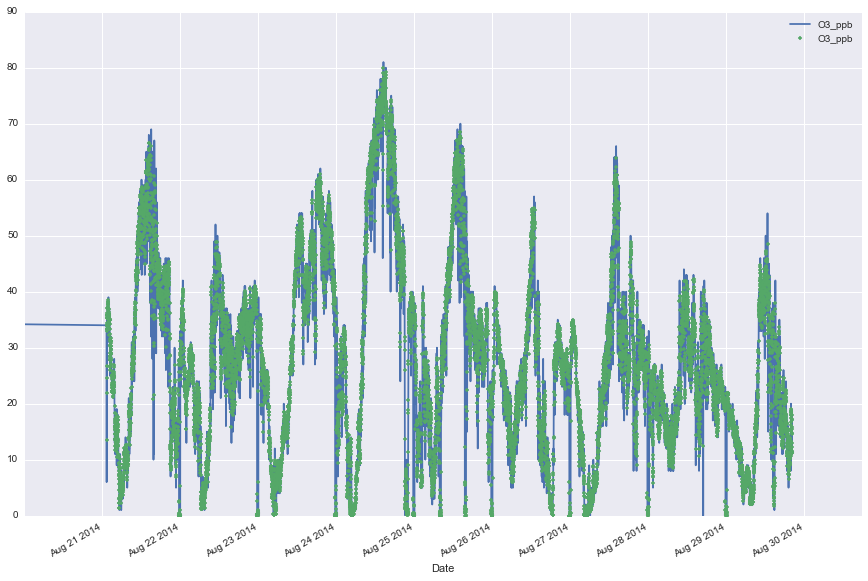

In [39]:
#plot the reference data
df_fit['O3_ppb'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_fit_copy['O3_ppb'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10), xlim=['2014-08-20 00:21:57', '2014-08-30 17:41:00'])
#plt.show()
#, xlim=['2014-07-07 00:21:57', '2014-07-11 17:41:00']

##Plot the reference data versus the predicted data.

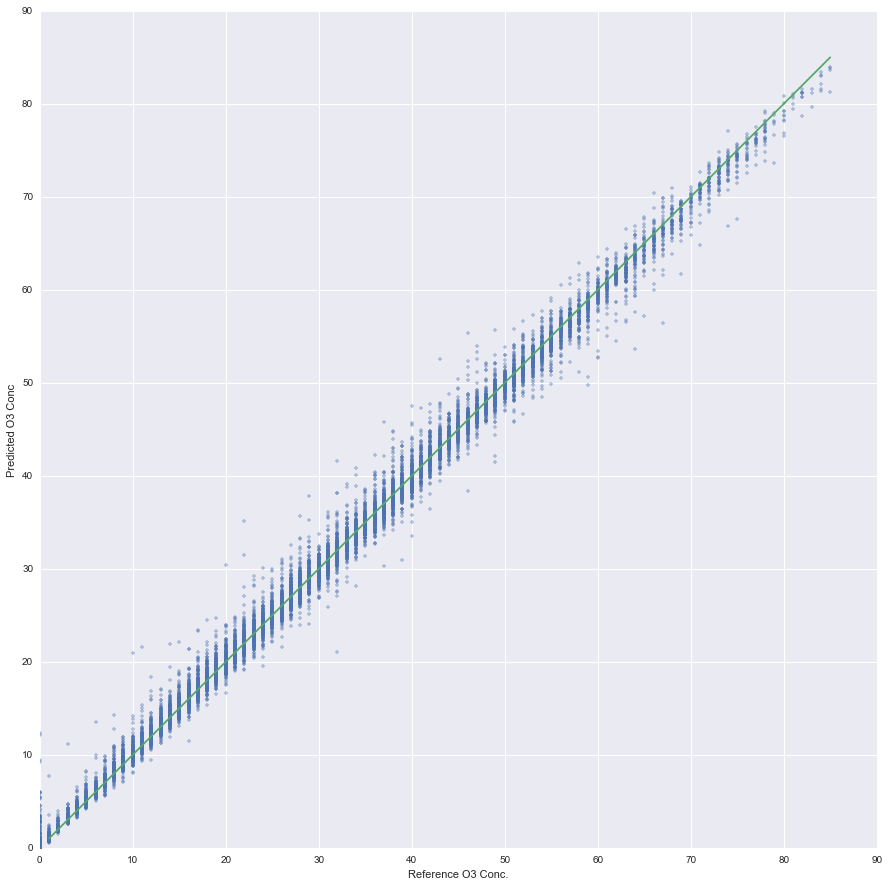

In [40]:
plt.figure(figsize = (15,15))
plt.plot(y,y_pred,linestyle = '',marker = '.',alpha = 0.4)
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85])

#Ridge Regression

In [198]:
fs_features = ['e2v03','Temp','Rh']

In [51]:
from sklearn.linear_model import Ridge

#define the training data
df_fit = df_all[fs_features + ['O3_ppb']].dropna()
X = df_fit[fs_features].values
y = df_fit['O3_ppb'].values
#print df_fit[:5]

###Find the best lambda value using cross-validation

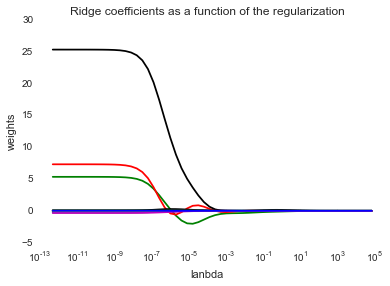

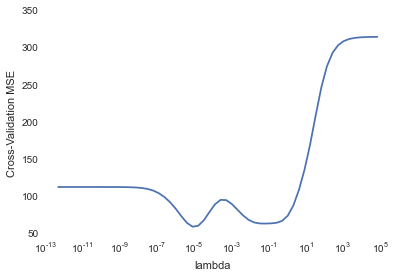

In [52]:
MSE_ridge = []
lambda_ridge = []
i = 0.0000000000005
n = 1
coefs = []
while i < 100000:
    ridge = Ridge(alpha=i, normalize = True)
    #fit the ridge regression for the lambda
    ridge.fit(X, y)
    #get the cross-validation scores
    scores = cvs(ridge, X, y, cv = 10, scoring='mean_squared_error')
    #record the score
    MSE_ridge.append(-scores.mean())
    #record the run number
    lambda_ridge.append(i)    
    coefs.append(ridge.coef_)
    i = i*2
    n += 1
        
#plot the coefficients     
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(lambda_ridge, coefs)
ax.set_xscale('log')
plt.xlabel('lanbda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.show()  
    
#find the lambda value that produces the lowest cross-validation MSE    
best_lambda = lambda_ridge[MSE_ridge.index(min(MSE_ridge))]

    
#plot the results
plt.plot(lambda_ridge, MSE_ridge)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('Cross-Validation MSE')

###Re-run the ridge regression with the lambda chosen above

In [53]:
ridge = Ridge(alpha=best_lambda, normalize = True)
#fit the ridge regression for the lambda
ridge.fit(X, y)
#get the cross-validation scores
scores = cvs(ridge, X, y, cv = 10, scoring='mean_squared_error')
print abs(scores.mean())

60.8195433503


####Define a function that finds the ridge regression for each day

In [54]:
#fit random forest and finds RSS
def rand_for_cv(features, df_F, df_H):
    
    #Set up the random forest regression features
    ridge = Ridge(alpha=best_lambda, normalize = True)
    
    #call the r=function that defines the trainig and holdout data
    X_T, y_T, X_H, y_H = df_subset(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    
    #fit a linear regression on the training data
    ridge.fit(X_T, y_T)  
    
    #find the normalized MSE for the training and holdout data
    return np.mean((y_H - ridge.predict(X_H))**2), np.mean((y_T - ridge.predict(X_T))**2)

####Find the MSE by holding out one day 

In [55]:
#define the dataset
df_fit = df_all[fs_features[:4] + ['O3_ppb']].dropna()

#create a 'day' column in the dataframe by mapping the index column
df_fit['day'] = df_fit.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
days = df_fit['day'].unique()
        
#initizlize the holdout and training RSS
MSE_T = []
MSE_H = [] 
day_date = []
count = 1
count_append = []
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
    MSE_H_temp, MSE_T_temp = rand_for_cv(fs_features[:4], df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    MSE_H.append(MSE_H_temp)
    MSE_T.append(MSE_T_temp)
    day_date.append(d)
    count +=1
    count_append.append(count)

#drop the day column
df_fit.drop('day', axis=1, inplace=True)

In [56]:
print 'mean MSE = ' + str(np.mean(MSE_H))
print 'Daily MSE = ' + str(MSE_H)

mean MSE = 68.843701133
Daily MSE = [166.42549162569745, 45.71346470755666, 81.950389105111952, 52.925227911797663, 27.499125629360215, 26.374277233405675, 49.53462063422959, 62.805699033777472, 106.36501431638098]


In [205]:
best_lambda = 0

In [201]:
ridge.coef_

array([ -1.38705318e-09,  -4.92507378e-12,  -1.85318810e-09,
         4.64340544e-10,   4.10544706e-22,  -3.58070150e-06,
         1.34886016e-14,   8.80120624e-12,  -1.27783541e-07,
        -1.71115427e-07,  -1.03623782e-09,   8.80024292e-08,
         3.88314633e-18,   1.25616582e-08,  -5.34821807e-08,
        -3.78603679e-08,   9.75705943e-10,   7.25231759e-08,
         1.10789132e-15,  -7.01709528e-16,   1.04489726e-09,
         1.81819039e-07,   4.22049747e-10,   9.88201693e-08,
         5.72219366e-10,  -3.06932668e-07,   2.20837108e-06,
        -3.29966503e-09,   9.73455811e-08,   2.54526837e-08,
         2.97295416e-10])

In [202]:
#Set the predictor variable. 
y_pred_ridge = ridge.predict(X)
print y-y_pred_ridge

[ -0.16161649   1.83835761  -1.16164108 ..., -29.16190474 -29.16192494
 -29.16191295]


In [203]:
#Calculate the training MSE
mse = np.mean((y - y_pred_ridge)**2)
print mse

303.293075673


In [204]:
#make a copy of the reference & pod data to manipulate
df_fit_ridge = df_fit.copy()
df_fit_ridge[:5]

,03_mult_temp45,03_mult_temp_sq,03_mult_temp30,03_mult_rh_&_temp,03_mult_rh_&_temp_cu,Temp,temp_mult_rh_sq,O3_cu,temp_int_45,temp_int_30,...,03_mult_rh45,rh_int_30,03_mult_rh30,temp_int_15,Rh,03_mult_temp15,temp_mult_rh,rh_sq,rh_cu,ref_o3_smooth
DATE (MM/DD/YYYY)_MST,,,,,,,,,,,,,,,,,,,,,
2014-07-10 21:10:00,193950.6272,18599011.63,127044.5048,50334.86980,1.275280e+14,44.200000,137289985.0,928897.9213,1987.780952,1302.066667,...,49044.51088,336.077381,32791.55017,626.850000,11.671429,61162.65000,515.877143,136.222245,1589.908201,29
2014-07-10 21:11:00,190016.0944,17758779.28,124463.0167,49305.16500,1.198610e+14,44.050000,136897438.9,875551.9630,1986.230952,1301.007143,...,48110.31111,336.421429,32184.31667,626.192857,11.700000,59905.78333,515.385000,136.890000,1601.613000,31
2014-07-10 21:12:00,190513.9429,17819011.87,124784.5714,49026.88653,1.178430e+14,43.971429,133195405.1,884736.0000,1984.520238,1299.839286,...,48314.28571,336.728571,32325.94286,625.382143,11.614286,60036.68571,510.696735,134.891633,1566.669962,28
2014-07-10 21:13:00,196849.0578,18935996.28,128934.5561,50167.16676,1.262580e+14,43.828571,129002590.0,978724.1254,1982.652381,1298.621429,...,50003.35884,336.907143,33450.06633,624.471429,11.528571,62001.09184,505.280816,132.907959,1532.238901,24
2014-07-10 21:14:00,203724.2449,20256612.78,133443.1837,52208.52245,1.423060e+14,43.757143,130773828.5,1088186.5890,1980.652381,1297.364286,...,51821.87755,336.885714,34651.10204,623.471429,11.600000,64128.48980,507.582857,134.560000,1560.896000,27


In [205]:
#plot the reference data
df_fit['O3_ppb'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_fit_ridge['O3_ppb'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10), xlim=['2014-07-07 00:00:00', '2014-07-11 00:00:00'])

KeyError: 'O3_ppb'

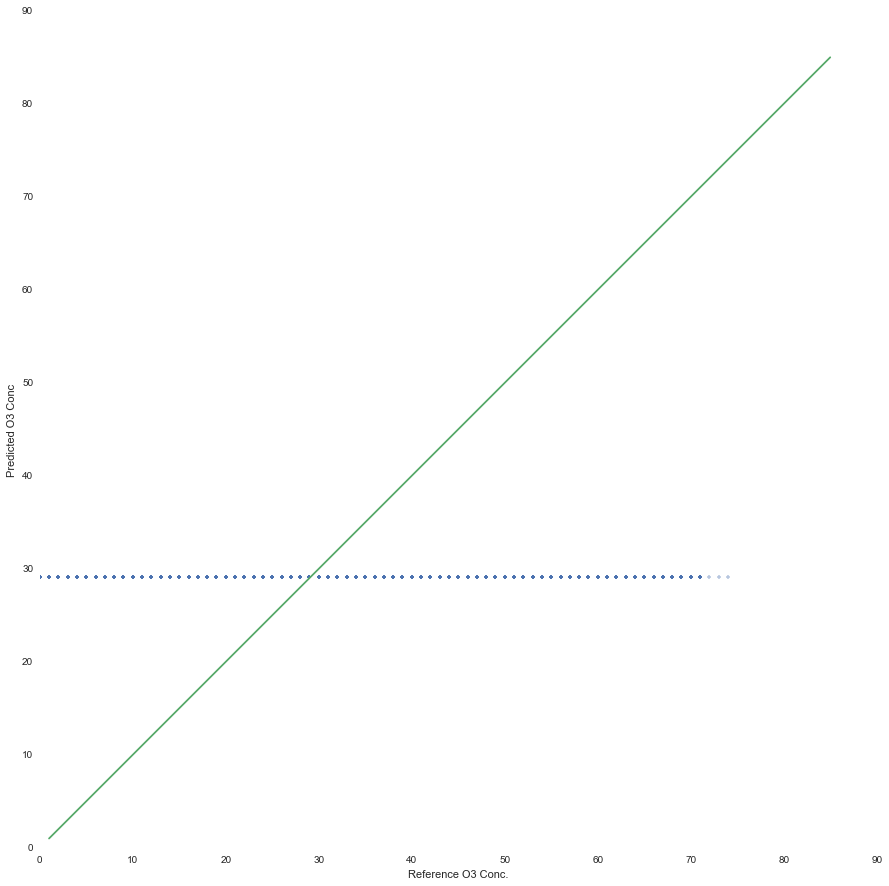

In [206]:
plt.figure(figsize = (15,15))
plt.plot(y,y_pred_ridge,linestyle = '',marker = '.',alpha = 0.4)
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85])

#Extremely Randomized Trees Regressor

In [192]:
efr = sk.ExtraTreesRegressor(n_estimators = 150, oob_score = True, bootstrap = True)

In [193]:
reg = efr.fit(X, y) 

In [194]:
efr.oob_score_

0.96838666081004265

In [195]:
efr.score(X,y)

0.99561305889037399

In [196]:
from sklearn.cross_validation import cross_val_score as cvs

#Get the random forest classifier results
clf = sk.ExtraTreesClassifier(n_estimators=150)
#get the cross-validation scores
scores = cvs(clf, X, y, cv = 10, scoring='r2')
scores.mean() 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:413: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


0.79840583027411627

In [197]:
scores

array([ 0.38052729,  0.85731779,  0.86681182,  0.94910679,  0.97095914,
        0.94401147,  0.92781704,  0.90514934,  0.92024377,  0.26211385])

In [198]:
#find the importance of each feature in the regression
efr.feature_importances_

array([ 0.04421643,  0.02073118,  0.02539547,  0.01631341,  0.01417942,
        0.0590038 ,  0.04190763,  0.01189003,  0.07765417,  0.05409885,
        0.05089661,  0.01058592,  0.01389787,  0.01516702,  0.05461709,
        0.02061267,  0.01402753,  0.06815952,  0.01460048,  0.02271306,
        0.01807739,  0.03076036,  0.03054903,  0.04368726,  0.02123209,
        0.04288161,  0.03800581,  0.01727528,  0.04095892,  0.03329685,
        0.03260725])

In [199]:
#Set the predictor variable. 
efc_pred = efr.predict(X)

In [200]:
#make a copy of the reference & pod data to manipulate
df_efc_pred = df_all.copy()

#change the reference data column in the new matrix to the predicted value
df_efc_pred['O3_ref'] = efc_pred

#plot the reference data
df_all['O3_ref'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_efc_pred['O3_ref'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10))
#plt.show()

KeyError: 'O3_ref'

##Compare the random forest and extra trees regressions

In [ ]:
plt.figure(figsize = (15,15))
plt.plot(y,efc_pred,linestyle = '',marker = '.',alpha = 0.7,label = 'Ext. For.')
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85], label = '1-to-1 line')
plt.plot(y,y_pred,linestyle = '',marker = '.',alpha = 0.2, label = 'Ran. For.')
plt.legend(loc='upper left', frameon = True)

#AdaBoost

In [ ]:
import sklearn.tree as tsk

#dt1 = tsk.DecisionTreeRegressor(max_depth=4) create single tree
ada = sk.AdaBoostRegressor(n_estimators = 175, learning_rate = 3)
staged_score = (X,y)

In [ ]:
#dt1_reg = dt1.fit(X,y)   
ada_reg = ada.fit(X,y)

In [ ]:
ada_reg.score(X,y)

In [ ]:
#Get the Ada Boost classifier results
ada_cv = sk.AdaBoostClassifier(n_estimators = 175, learning_rate = 3)
#get the cross-validation scores
scores = cvs(ada_cv, X, y, cv = 10, scoring='r2')
scores.mean() 

In [ ]:
#y_dt1 = dt1_reg.predict(X)
y_ada = ada_reg.predict(X)

#Set the predictor variable. 
ada_pred = ada_reg.predict(X)

#make a copy of the reference & pod data to manipulate
df_ada_pred = df_all.copy()

#change the reference data column in the new matrix to the predicted value
df_ada_pred['O3_ref'] = ada_pred

#plot the reference data
df_all['O3_ref'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_ada_pred['O3_ref'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10))
#plt.show()

In [ ]:
plt.figure(figsize = (15,15))
plt.plot(y,efc_pred,linestyle = '',marker = '.',alpha = 0.7,label = 'Ext. Forest')
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85], label = '1-to-1 line')
plt.plot(y,y_pred,linestyle = '',marker = '.',alpha = 0.7, label = 'Ran. Forest')
plt.plot(y,y_ada,linestyle = '',marker = '.',alpha = 0.6, label = 'Ada Boost', c = 'y')
plt.legend(loc='upper left', frameon = True)

#Gradient Boost

In [ ]:
gbr = sk.GradientBoostingRegressor(n_estimators = 1000)
gbr_reg = gbr.fit(X,y)

In [ ]:
#gbr.train_score_

In [ ]:
gbr.feature_importances_

In [ ]:
gbr.score(X,y)

In [ ]:
#y_dt1 = dt1_reg.predict(X)
y_gbr = gbr_reg.predict(X)

#Set the predictor variable. 
gbr_pred = gbr_reg.predict(X)

#make a copy of the reference & pod data to manipulate
df_gbr_pred = df_all.copy()

#change the reference data column in the new matrix to the predicted value
df_gbr_pred['O3_ref'] = ada_pred

#plot the reference data
df_all['O3_ref'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_gbr_pred['O3_ref'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10))
#plt.show()

In [ ]:
plt.figure(figsize = (15,15))
plt.plot(y,efc_pred,linestyle = '',marker = '.',alpha = 0.7,label = 'Ext. Forest')
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85], label = '1-to-1 line')
plt.plot(y,y_pred,linestyle = '',marker = 'd',alpha = 1, label = 'Ran. Forest', c = 'w')
plt.plot(y,y_ada,linestyle = '',marker = '.',alpha = 0.6, label = 'Ada Boost', c = 'y')
plt.plot(y,y_gbr,linestyle = '',marker = '.',alpha = 0.3, label = 'Grad Boost', c = 'g')
plt.legend(loc='upper left', frameon = True)

#Linear Regression

In [289]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()

####fit the data using a linear regression model

In [290]:
lin_reg = regr.fit(X, y)

####Print the coefficients


In [291]:
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([  1.92241825e+00,  -1.45521807e+00,  -1.97282308e+01,
        -5.86662981e-07,  -5.77278222e-07,   6.39033338e-03,
         1.61787706e-02,  -2.82337506e-03,   4.53303019e-02,
         6.13730089e-05,  -5.28942262e-03,  -2.15747706e-02,
         5.59376824e-05,  -5.26031635e-02,  -6.13235679e-03,
        -1.98074200e-10,  -5.90146090e-07,  -5.90146090e-07,
         6.60564749e-01]))


In [292]:
import sklearn.cross_validation 
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:
predicted = sklearn.cross_validation.cross_val_predict(regr, X, y, cv=10)

AttributeError: 'module' object has no attribute 'cross_val_predict'

In [293]:
#Set the predictor variable. 
lin_pred = lin_reg.predict(X)

#make a copy of the reference & pod data to manipulate
df_lin_pred = df_all.copy()

#change the reference data column in the new matrix to the predicted value
df_lin_pred['O3_ref'] = lin_pred

#plot the reference data
df_all['O3_ref'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_lin_pred['O3_ref'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10))
#plt.show()

KeyError: 'O3_ref'

In [294]:
plt.figure(figsize = (15,15))
plt.plot(y,efc_pred,linestyle = '',marker = '.',alpha = 0.7,label = 'Ext. Forest')
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85], label = '1-to-1 line')
plt.plot(y,y_pred,linestyle = '',marker = 'd',alpha = 1, label = 'Ran. Forest', c = 'w')
plt.plot(y,y_ada,linestyle = '',marker = '.',alpha = 0.6, label = 'Ada Boost', c = 'y')
plt.plot(y,y_gbr,linestyle = '',marker = '.',alpha = 0.3, label = 'Grad Boost', c = 'g')
plt.plot(y,lin_pred,linestyle = '',marker = 's',alpha = 0.3, label = 'Lin. Reg.', c = 'r')
plt.legend(loc='upper left', frameon = True)

NameError: name 'efc_pred' is not defined

In [ ]:
a = np.array(y)
b = np.array(y_pred)
c = np.column_stack((a,b))
#sns.heatmap(c, vmin = 30)

In [ ]:
px2 = a.reshape((-1,3))
df = pd.DataFrame({'R':px2[:,0],'G':px2[:,1],'B':px2[:,2]})

In [ ]:
import logloss
llfun(df_all['O3_ref'],df_all_pred['O3_ref'])

In [ ]:
scores